In [3]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import glob
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import os
from collections import defaultdict

from sklearn import decomposition
from sklearn import preprocessing

from scripts import aesthetics

aesthetics.activate_paper_rcParams('illustrator')

from scripts import manuscript_colors as mc

# RNA Analysis

In this notebook, we analyze the outputs of `sv-impact-on-rna-generate.ipynb` to make figures.

__Note:__ This notebook makes use of the nice statistical properties of the null uniform distribution of ranks to do calculations. See the methods of the paper for further details.

# Read in data

In [4]:
rna_data = pd.read_csv('data/rna/gmkf_neuroblastoma_tpms.csv', index_col = 0)
dosages = pd.read_csv('data/rna/dosages-for-sv-rna-analysis.csv').iloc[:, 3:].set_index("ID")

In [5]:
# read in the SVs used in the RNA analysis
analysis_svs = pd.read_csv('data/rna/svs-for-sv-rna-analysis.csv')

# and our actual results
sv_rna_results = pd.read_csv('data/rna/sv-gene-rna-results.csv')

/Users/jettcrowdis/opt/anaconda3/envs/pedsv-test-conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (34,35,37,39,41,45,46,47) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [6]:
sv_rna_results.head(2)

,name,sv_effect,genic_relationship,gene,sv_coding_counts,sv_noncoding_counts,sv_unimportant_coding_counts,#chrom_x,start_x,end_x,...,end_y,svtype_y,distance,mean_exp,num_rna_genotyped,num_greater_0_dosage,mean_greater_0_dosage_rank,mean_greater_0_exp,mean_leq_0_exp,mwu_p
0,PedSV.2.5.2_CNV_chr1_6,noncoding,PREDICTED_NEAREST_TSS,OR4F29,0.0,1.0,0.0,chr1,257666,262901,...,262901,CNV,187839.0,0.266629,89,15,0.492045,0.247333,0.270541,0.912668
1,PedSV.2.5.2_CNV_chr1_7,noncoding,PREDICTED_NEAREST_TSS,OR4F29,0.0,1.0,0.0,chr1,262333,288667,...,288667,CNV,162073.0,0.266629,89,62,0.489736,0.255484,0.292222,0.620135


Now we load the categories

In [7]:
###########
### SVs ###
###########
category_svs = []
for file in glob.glob("data/cwas/svs-in-categories/*.txt"):
    disease = file.split("/")[-1].split("_")[0]

    sv_category = "noncoding" if "noncoding" in file else "coding"

    cat_svs = pd.read_csv(file, sep="\t")
    cat_svs[["disease", "sv_category"]] = [disease, sv_category]
    category_svs.append(cat_svs)

category_svs = pd.concat(category_svs)
category_svs.head(2)

,SV,chrom,start,end,category,disease,sv_category
0,PedSV.2.5.2_DUP_chr1_794,chr1,19221626,19301822,DUP.RARE.PREDICTED_COPY_GAIN.lof_constrained.e...,neuroblastoma,coding
1,PedSV.2.5.2_DUP_chr1_1379,chr1,44731601,44792024,DUP.RARE.PREDICTED_COPY_GAIN.lof_constrained.e...,neuroblastoma,coding


In [8]:
#########################
### FRAMEWORK RESULTS ###
#########################
columns = ['category_name', 'point_estimate', 'std_error', 'z_score', 'p_value']
framework_results = []
for file in glob.glob("data/cwas/summary-stats/*.txt"):

    disease = file.split("/")[-1].split("_")[0]

    sv_category = "noncoding" if "noncoding" in file else "coding"

    data = pd.read_csv(file, sep="\t", usecols = columns)
    data[["disease", "sv_category"]] = [
        disease,
        sv_category,
    ]
    framework_results.append(data)

framework_results = pd.concat(framework_results)
framework_results['negative_log10_p_value'] = -np.log10(framework_results['p_value'])

In [9]:
num_tests = {
    "neuroblastoma-coding": 324,
    "neuroblastoma-noncoding": 940,
    "ewing-coding": 324,
    "ewing-noncoding": 918,
}

bonf_nlp_thresholds = {d: -np.log10(0.05 / n_test) for d, n_test in num_tests.items()}

framework_results["bonferroni_p"] = framework_results.apply(
    lambda row: row["p_value"] * num_tests[row["disease"] + "-" + row["sv_category"]],
    axis=1,
)

framework_results["bonferroni_significant"] = framework_results["bonferroni_p"] < 0.05

In [10]:
framework_results.head(2)

,point_estimate,std_error,z_score,p_value,category_name,disease,sv_category,negative_log10_p_value,bonferroni_p,bonferroni_significant
0,0.086070,0.317723,0.270895,0.786472,DUP.RARE.PREDICTED_COPY_GAIN.lof_constrained.e...,ewing,coding,0.104317,254.816767,False
1,-0.403845,0.430204,-0.938729,0.347870,DUP.RARE.PREDICTED_COPY_GAIN.ANY.ANY.signaling...,ewing,coding,0.458583,112.709843,False


In [11]:
framework_results.query('bonferroni_significant == True').groupby(['disease', 'sv_category']).size()

disease        sv_category
neuroblastoma  coding         29
               noncoding       6
dtype: int64

# Examine all coding/non-coding SVs

Before determining if individual categories have an "effect" on expression, we'll do it for all coding or noncoding SVs

In [12]:
# First identify single-sample, single-gene SVs
noncoding_ss_sg_svs = sv_rna_results.query('sv_noncoding_counts == 1 & num_greater_0_dosage == 1 & sv_coding_counts == 0 & sv_unimportant_coding_counts == 0')
coding_ss_sg_svs = sv_rna_results[((sv_rna_results['sv_coding_counts'] == 1) | (sv_rna_results['sv_unimportant_coding_counts'] == 1)) &
                                  (sv_rna_results['sv_noncoding_counts'] == 0) &
                                  (sv_rna_results['num_greater_0_dosage'] == 1)]

# in cases where an SV has both an important and unimportant coding effect, keep the important
coding_ss_sg_svs = coding_ss_sg_svs.sort_values(by = 'sv_effect').drop_duplicates(subset = ['name'])

single_gene_sample_svs = pd.concat([coding_ss_sg_svs, noncoding_ss_sg_svs])

print(single_gene_sample_svs[['sv_effect']].value_counts())

sv_effect         
noncoding             7940
coding                 196
unimportant_coding      37
dtype: int64


196 coding p = 0.028457869182546447 mean = 0.44837902972600807
7940 noncoding p = 0.9998765039234522 mean = 0.502915461888094
37 unimportant_coding p = 0.5558200082237269 mean = 0.5669891977877831


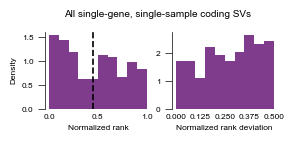

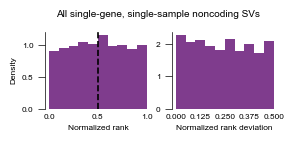

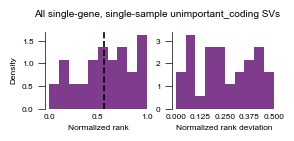

In [13]:
for sv_effect in ['coding', 'noncoding', 'unimportant_coding']:

    # get the data
    ss_sg_svs = single_gene_sample_svs.query(f'sv_effect == "{sv_effect}"')
    
    # calculate the rank deviation from 0.5
    rank_deviation = np.abs(0.5 - ss_sg_svs['mean_greater_0_dosage_rank'])

    # plot the rank deviation
    fig, axes = plt.subplots(1, 2, figsize = (3, 1))
    axes[0].hist(ss_sg_svs['mean_greater_0_dosage_rank'], 
                 bins = np.arange(0, 1.1, 0.1), density = True)
    axes[0].axvline(x = ss_sg_svs['mean_greater_0_dosage_rank'].mean(), linestyle = 'dashed', color = 'black')
    axes[1].hist(rank_deviation, bins = np.arange(0, 0.55, 0.05),
                 density = True)

    for ax in axes:
        sns.despine(ax = ax, bottom = True)
        ax.tick_params(axis = 'x', length = 0)

    axes[0].set_xlim([-0.04, 1.04])
    axes[1].set_xlim([-0.02, 0.52])
    axes[1].set_xticks([0, 0.125, 0.25, 0.375, 0.5])

    axes[0].set_xlabel('Normalized rank')
    axes[1].set_xlabel('Normalized rank deviation')
    axes[0].set_ylabel('Density')

    # calculate a p value - see methods of the paper
    num_genes = len(ss_sg_svs)
    ref_dist = stats.norm(loc = 0.25, scale = np.sqrt(1/(48 * num_genes)))
    p = 1 - ref_dist.cdf(rank_deviation.mean())
    print(num_genes, sv_effect, 'p =', p, 'mean =', ss_sg_svs['mean_greater_0_dosage_rank'].mean())

    fig.suptitle(f'All single-gene, single-sample {sv_effect} SVs', y = 1.1)

    # fig.savefig(f'images/single-sample-single-gene-{sv_effect}-effect-on-expression.png', bbox_inches = 'tight')

So we can see that the 196 coding SVs--on average--tend to result in lower expression ranks for the samples they affect. The effect is not significant for noncoding SVs or "unimportant" coding SVs (ie SVs not included in the CWAS)

# Calculate for all coding SVs and all noncoding SVs

We do the same as above but actually formalize it, as well as break down deletions, etc

In [14]:
all_singleton_svs = {}
all_results = []
for sv_effect in ['all_coding', 'noncoding', 'deletions']:
    
    if sv_effect in ['coding', 'noncoding']:
        all_svs = single_gene_sample_svs.query(f'sv_effect == "{sv_effect}"')
    elif sv_effect == "all_coding":
        all_svs = single_gene_sample_svs[single_gene_sample_svs['sv_effect'].isin(['coding', 'unimportant_coding'])]
    elif sv_effect == "deletions":
        all_svs = single_gene_sample_svs.query('genic_relationship == "PREDICTED_LOF"')
    elif sv_effect == "utr":
        all_svs = single_gene_sample_svs.query('genic_relationship == "PREDICTED_UTR"')

    rank_deviation = np.mean(np.abs(0.5 - all_svs['mean_greater_0_dosage_rank']))

    num_genes = len(all_svs)
    ref_dist = stats.norm(loc = 0.25, scale = np.sqrt(1/(48 * num_genes)))
    p_mean = 1 - ref_dist.cdf(rank_deviation)
    p_mean = 2 * p_mean if p_mean < 0.5 else 1
    rank_mean = np.mean(all_svs['mean_greater_0_dosage_rank'])

    print(sv_effect, p_mean, rank_mean, num_genes)
    
    all_singleton_svs[sv_effect] = all_svs['mean_greater_0_dosage_rank'].values
    
    all_results.append([sv_effect, rank_deviation, num_genes, p_mean, rank_mean])
    
all_results = pd.DataFrame(all_results, columns = ['sv_effect', 'rank_deviation', 'num_genes', 'p_mean', 'rank_mean'])
all_results['-log10(p_mean)'] = -np.log10(all_results['p_mean'])

all_coding 0.09096811007128158 0.4672141207916118 233
noncoding 1 0.502915461888094 7940
deletions 0.18228448515782913 0.4298061453556176 155


In [15]:
all_results

,sv_effect,rank_deviation,num_genes,p_mean,rank_mean,-log10(p_mean)
0,all_coding,0.265983,233,0.090968,0.467214,1.041111
1,noncoding,0.244063,7940,1.000000,0.502915,-0.000000
2,deletions,0.265463,155,0.182284,0.429806,0.739250


We can see that deletions do lead to a lower rank of expression (0.42), but the effect is not significant because samples are lost.

# Examine categories

Now that we have the "high level" SV classes (coding, noncoding, deletions), we take a look at categories specifically.

In [16]:
nbl_categories = framework_results.query('disease == "neuroblastoma"')

We now need to calculate significance for ALL these categories.

In [17]:
nbl_coding_category_svs = category_svs.query('disease == "neuroblastoma"')

# make a dictionary that can look up the SVs for a given category
cat_to_svs = defaultdict(list)
for cat, sv in zip(nbl_coding_category_svs['category'], nbl_coding_category_svs['SV']):
    cat_to_svs[cat].append(sv)

In [18]:
p_vals = []
for index, row in nbl_categories.iterrows():
    cat = row['category_name']
    sv_effect = row['sv_category']
    
    # get the SVs in the category
    svs_in_category = cat_to_svs[cat]
    
    # get the RNA results for these SVs
    category_rna_results = single_gene_sample_svs[(single_gene_sample_svs['name'].isin(svs_in_category))]
    
    # attempt to calculate a p value
    try:
        rank_deviation = np.mean(np.abs(0.5 - category_rna_results['mean_greater_0_dosage_rank']))

        num_genes = len(category_rna_results)
        ref_dist = stats.norm(loc = 0.25, scale = np.sqrt(1/(48 * num_genes)))
        p_mean = 1 - ref_dist.cdf(rank_deviation)
        
        # two sided P value
        p_mean = 2 * p_mean if p_mean < 0.5 else 1
        rank_mean = np.mean(category_rna_results['mean_greater_0_dosage_rank'])

    # will fail in a few instances (e.g. no RNA present)
    except:
        p_mean = np.nan
        rank_mean = np.nan
        num_genes = 0
        
    # if the category is significant, we bootstrap against the background of all SVs
    if row['bonferroni_significant'] and sv_effect == 'coding':
        
        reference = all_singleton_svs['all_coding']
        
        bs = np.random.choice(reference, size = (num_genes, 1000000))
        
        bs_mean_ranks = np.mean(bs, axis = 0)
        
        p_bs = (bs_mean_ranks < rank_mean).mean()
        
    else:
        p_bs = np.nan
        
    p_vals.append([sv_effect, cat, num_genes, p_mean, rank_mean, p_bs])
    
p_vals = pd.DataFrame(p_vals, columns = ['sv_category', 'category_name', 'num_genes_rna', 'p_mean', 'rank_mean', 'p_bs'])

In [19]:
p_vals.head(2)

,sv_category,category_name,num_genes_rna,p_mean,rank_mean,p_bs
0,noncoding,ANY.SINGLETON.PREDICTED_NONCODING_BREAKPOINT.n...,46,1.000000,0.447290,NaN
1,noncoding,ANY.SINGLETON.PREDICTED_NONCODING_BREAKPOINT.n...,21,0.549807,0.371856,NaN


In [20]:
p_vals.query('p_mean < 0.05 & sv_category == "coding"')

,sv_category,category_name,num_genes_rna,p_mean,rank_mean,p_bs
7907,coding,DEL.SINGLETON.ANY.unconstrained.expressed_in_a...,5,0.005411,0.188636,NaN
8018,coding,ANY.RARE.PREDICTED_COPY_GAIN.ANY.ANY.protein_c...,15,0.031985,0.529924,NaN
8065,coding,ANY.RARE.PREDICTED_LOF_or_PREDICTED_PARTIAL_EX...,13,0.002337,0.243541,NaN
8134,coding,ANY.RARE.ANY.unconstrained.expressed_in_adrena...,16,0.006848,0.247593,NaN
8145,coding,ANY.RARE.ANY.ANY.expressed_in_adrenal_gland.pr...,50,0.023534,0.383688,0.024400
8163,coding,ANY.RARE.ANY.ANY.ANY.chromatin_organization_genes,2,0.034390,0.534091,NaN
8182,coding,ANY.SINGLETON.PREDICTED_COPY_GAIN.ANY.expresse...,3,0.018097,0.386364,NaN
8228,coding,ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTI...,6,0.001823,0.316288,NaN
8288,coding,ANY.SINGLETON.ANY.unconstrained.expressed_in_a...,8,0.001243,0.272727,NaN
8300,coding,ANY.SINGLETON.ANY.ANY.expressed_in_adrenal_gla...,25,0.030078,0.358211,0.034477


## Plot figure 4f (coding results)

From this, we make figure 4f

In [21]:
nbl_categories = nbl_categories.merge(p_vals, on = ['category_name', 'sv_category'])
nbl_categories['-log10(p_mean)'] = -np.log10(nbl_categories['p_mean'])

In [22]:
palette = {'noncoding': mc.palette['neuroblastoma']['light2'],
           'coding': mc.palette['neuroblastoma']['main'],
           'all_coding': mc.palette['neuroblastoma']['main'],
           'deletions': mc.palette['neuroblastoma']['main']}

We only plot points for categories that are significant and singleton

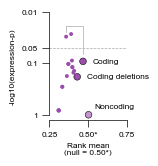

In [23]:
plotted_categories = nbl_categories.query('bonferroni_significant')
plotted_categories = plotted_categories[plotted_categories['category_name'].str.contains('SINGLETON')]

fig, ax = plt.subplots(1, figsize = (1, 1.4))
sns.scatterplot(x = 'rank_mean', y = '-log10(p_mean)', data = plotted_categories.query('sv_category == "coding"'), 
                hue = 'sv_category', ec = None, s = 8, palette = palette)
ax.set_xlabel('Rank mean\n(null = 0.50*)')
ax.set_ylabel('-log10(expression-p)')
sns.despine(ax = ax)
ax.set_xlim([0, 1])
# ax.axvline(x = 0.5, linewidth = 0.50, linestyle = 'dashed', color = 'darkgrey', zorder = -2)
ax.axhline(y = -np.log10(0.05), linestyle = 'dashed', color = 'darkgrey', linewidth = 0.5)

ax.set_xlim([0.25, 0.75])
ax.set_xticks([0.25, 0.50, 0.75])
ax.set_xticklabels(['0.25', '0.50*', '0.75'])
ax.legend(bbox_to_anchor = (1, 0.5))
ax.set_ylim([-0.1, 2])
ax.spines['left'].set_bounds([0, 2])

# plot the ALL "categories"
sns.scatterplot(x = 'rank_mean', y = '-log10(p_mean)', data = all_results, 
                hue = 'sv_effect', ec = 'black', linewidths = 10, palette = palette)


ax.set_yticks([0, 1, -np.log10(0.05), 2])
ax.set_yticklabels(['1', '0.1', '0.05', '0.01'])

# draw the grey line
top = plotted_categories.query('category_name == "ANY.SINGLETON.ANY.ANY.expressed_in_adrenal_gland.protein_coding"').iloc[0]
end = all_results.query('sv_effect == "all_coding"').iloc[0]

x_path = [top['rank_mean'], top['rank_mean'], end['rank_mean'], end['rank_mean']]
y_path = [top['-log10(p_mean)'] + 0.10, top['-log10(p_mean)'] + 0.2, top['-log10(p_mean)'] + 0.2, end['-log10(p_mean)'] + 0.15]

ax.plot(x_path, y_path, color = 'darkgrey', linewidth = 0.5)

labels = ['Coding', 'Noncoding', 'Coding deletions']
for index, row in all_results.iterrows():
    x = row['rank_mean']
    y = row['-log10(p_mean)']
    if index == 1:
        y += 0.15
        x -= 0.02
    ax.text(s = labels[index], x = x + 0.06, y = y, ha = 'left', va = 'center')

ax.legend().remove()

fig.savefig('figures/fig4f.pdf', bbox_inches = 'tight')

## Try noncoding

There are no noncoding categories that are significant between cases and controls. If we relax our thresholds and simply require p < 0.10 (ie non bonferroni-corrected), we see three categories:

In [24]:
nbl_categories[lambda row: row['category_name'].str.contains('SINGLETON')].query('sv_category == "noncoding" & p_mean < 0.05 & p_value < 0.10')

,point_estimate,std_error,z_score,p_value,category_name,disease,sv_category,negative_log10_p_value,bonferroni_p,bonferroni_significant,num_genes_rna,p_mean,rank_mean,p_bs,-log10(p_mean)
608,0.186366,0.098241,1.897024,0.057825,DEL.SINGLETON.ANY.recombination_hotspot.ANY.AN...,neuroblastoma,noncoding,1.237886,54.355257,False,12,0.002278,0.526006,NaN,2.642506
711,0.668998,0.367315,1.821320,0.068558,DEL.SINGLETON.ANY.neuroblastoma_encode_consens...,neuroblastoma,noncoding,1.163941,64.444711,False,2,0.016674,0.505682,NaN,1.777961
829,0.475822,0.273287,1.741109,0.081665,ANY.SINGLETON.PREDICTED_NONCODING_SPAN.recombi...,neuroblastoma,noncoding,1.087967,76.764642,False,2,0.019380,0.511364,NaN,1.712657


Two of these have only 2 genes, and the other ostensibly leads to an increase in expression (rank_mean = 0.53). This is inconsistent with known biology and n = 1, so we do not report it.

# Make a heatmap

We create a heatmap to visually demonstrate how germline SVs affect tumor expression.

In [25]:
# heatmap_cat = 'DEL.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.ANY.protein_coding'
heatmap_cat = 'ANY.SINGLETON.ANY.ANY.expressed_in_adrenal_gland.protein_coding'
cat_svs = cat_to_svs[heatmap_cat]

In [26]:
# get the results for this category
heatmap_rna_results = single_gene_sample_svs[single_gene_sample_svs['name'].isin(cat_svs)].sort_values(by = 'mean_greater_0_dosage_rank').reset_index()

genes = heatmap_rna_results['gene'].tolist()
samples = list(dosages.columns)

In [27]:
# we reorder genes such that the rank of the sample that is affected by the SV is monotonically increasing
sample_ordering_results = []
for i, row in heatmap_rna_results.iterrows():
    sv = row['name']
    gene = row['gene']
    sv_dosages = dosages.loc[sv]
    samples_with_sv = list(sv_dosages[sv_dosages > 0].index)

    # only singleton SVs here
    assert len(samples_with_sv) == 1
    
    # identify the sample with the SV
    samp_with_sv = samples_with_sv[0]
    
    # get its rank
    expression = rna_data.loc[gene, samples].sort_values()
    s_idx = expression.index.tolist().index(samp_with_sv)
    
    sample_ordering_results.append([samp_with_sv, gene, s_idx])

# order by rank and get the gene order
sample_ordering_results = pd.DataFrame(sample_ordering_results, columns = ['sample', 'gene', 'rank']).sort_values(by = 'rank').reset_index(drop = True)
gene_order = sample_ordering_results['gene'].tolist()

Now we plot

In [28]:
# create a color map using our neuroblastoma color palette
cmap = mpl.colors.LinearSegmentedColormap.from_list('custom', ['white', mc.palette['neuroblastoma']['light2'], mc.palette['neuroblastoma']['dark1']], N = 256)

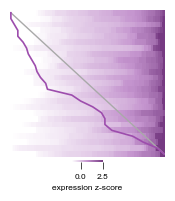

In [29]:
# make the figure, add a gridspec
fig = plt.figure(figsize=(2, 2.3))
gs = fig.add_gridspec(1)

# get the heatmap data
heatmap_exp = rna_data.loc[gene_order, samples]
heatmap_cols = heatmap_exp.columns

heatmap_exp_values = heatmap_exp.values

# we now need to scramble the rows by sorting by expression
ordered_indices = np.argsort(heatmap_exp_values, axis = 1)
heatmap_exp_values = np.sort(heatmap_exp_values, axis = 1)

# create a mask for 0 expression
mask = (heatmap_exp_values == 0)
masked_data = np.where(mask, heatmap_exp_values, np.nan)

# convert heatmap data to zscore
heatmap_exp_values = stats.zscore(heatmap_exp_values, axis = 1)

# plot the heatmap
heatmap_ax = fig.add_subplot(gs[0])

norm = mpl.colors.Normalize(vmin=-1, vmax=2.5)
sns.heatmap(heatmap_exp_values, cmap=cmap, norm = norm, 
            ax = heatmap_ax, cbar_kws={"orientation": "horizontal", "pad":0.02, 'shrink': 0.2})

# label the colorbar
cbar = heatmap_ax.collections[0].colorbar
cbar.set_label('expression z-score')

# ignore the y axis
aesthetics.strip_axis(ax = heatmap_ax)
heatmap_ax.tick_params(axis = 'y', length = 0)

# label the samples with SVs
sv_plot = []
for i, row in sample_ordering_results.iterrows():
    rank = row['rank']
    sv_plot.append([rank + 0.5, i + 0.5])
    
    
sv_plot = np.array(sv_plot)
heatmap_ax.plot(sv_plot[:, 0], sv_plot[:, 1], color = mc.palette['neuroblastoma']["main"], zorder = 2)

heatmap_ax.plot([0.5, 88.5], [0.5, len(heatmap_exp) - 0.5], 
                color = 'darkgrey', linewidth = 1, zorder = 1)

fig.savefig('figures/fig4e.pdf', bbox_inches = 'tight')

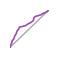

In [30]:
# make a little legend
fig, ax = plt.subplots(1, figsize = (0.5, 0.5))
ax.set_ylim([0, len(heatmap_exp)])
ax.set_xlim([0, 89])
aesthetics.strip_axis(ax)

ax.plot(sv_plot[:, 0], sv_plot[:, 1], color = mc.palette['neuroblastoma']["main"], zorder = 2)

ax.plot([0.5, 88.5], [0.5, len(heatmap_exp) - 0.5], 
         color = 'darkgrey', linewidth = 1, zorder = 1)
fig.savefig('figures/expression-heatmap-legend.pdf', bbox_inches = 'tight')

# Supplements

Make some supplemental figures - just another large heatmap for all coding SVs. Repeated code from above.

In [31]:
heatmap_rna_results = single_gene_sample_svs.query('sv_effect == "coding"').sort_values(by = 'mean_greater_0_dosage_rank').reset_index()

genes = heatmap_rna_results['gene'].tolist()
samples = list(dosages.columns)

In [32]:
# unfortunately, we actually need to reorder these results. We do this such that the RANK is controlled and monotonically increasing
sample_ordering_results = []
for i, row in heatmap_rna_results.iterrows():
    sv = row['name']
    gene = row['gene']
    sv_dosages = dosages.loc[sv]
    samples_with_sv = list(sv_dosages[sv_dosages > 0].index)

    # only singleton SVs here
    assert len(samples_with_sv) == 1
    
    samp_with_sv = samples_with_sv[0]
    
    expression = rna_data.loc[gene, samples].sort_values()
    s_idx = expression.index.tolist().index(samp_with_sv)
    
    sample_ordering_results.append([samp_with_sv, gene, s_idx])

sample_ordering_results = pd.DataFrame(sample_ordering_results, columns = ['sample', 'gene', 'rank']).sort_values(by = 'rank').reset_index(drop = True)
gene_order = sample_ordering_results['gene'].tolist()

Make the plot

In [33]:
cmap = mpl.colors.LinearSegmentedColormap.from_list('custom', ['white', mc.palette['neuroblastoma']['light2'], mc.palette['neuroblastoma']['dark1']], N = 256)

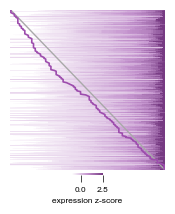

In [34]:
heatmap_exp = rna_data.loc[gene_order, samples]
heatmap_cols = heatmap_exp.columns

heatmap_exp_values = heatmap_exp.values

# we now need to scramble the rows by sorting by expression
ordered_indices = np.argsort(heatmap_exp_values, axis = 1)
heatmap_exp_values = np.sort(heatmap_exp_values, axis = 1)

# create a mask for 0 expression
mask = (heatmap_exp_values == 0)
masked_data = np.where(mask, heatmap_exp_values, np.nan)

# convert heatmap data to zscore
heatmap_exp_values = stats.zscore(heatmap_exp_values, axis = 1)

fig = plt.figure(figsize=(2, 2.5))# 2.8))
gs = fig.add_gridspec(1)

# plot the heatmap
heatmap_ax = fig.add_subplot(gs[0])

norm = mpl.colors.Normalize(vmin=-1, vmax=2.5)
sns.heatmap(heatmap_exp_values, cmap=cmap, norm = norm, 
            ax = heatmap_ax, cbar_kws={"orientation": "horizontal", "pad":0.02, 'shrink': 0.2})

# label the colorbar
cbar = heatmap_ax.collections[0].colorbar
cbar.set_label('expression z-score')

example_genes = [0, 3, 5, 7, 9, 13, 15, 20, 24, 26, 31, 35]
heatmap_ax.set_yticks(np.array(example_genes) + 0.6)
heatmap_ax.set_yticklabels(np.array(gene_order)[example_genes], rotation = 0, ha = 'right', va = 'center',
                           fontstyle = 'italic', fontsize = 6);

# actually going to ignore the y axis for now
aesthetics.strip_axis(ax = heatmap_ax)
heatmap_ax.tick_params(axis = 'y', length = 0)

# label the samples with SVs
sv_plot = []
for i, row in sample_ordering_results.iterrows():
    rank = row['rank']
    # heatmap_ax.scatter(x = rank + 0.5, y = i + 0.5, color = 'black', s = 1, label = label_s)
    sv_plot.append([rank + 0.5, i + 0.5])
    
    
sv_plot = np.array(sv_plot)
heatmap_ax.plot(sv_plot[:, 0], sv_plot[:, 1], color = mc.palette['neuroblastoma']["main"], zorder = 2)

heatmap_ax.plot([0.5, 88.5], [0.5, len(heatmap_rna_results) - 0.5], 
                color = 'darkgrey', linewidth = 1, zorder = 1)

fig.savefig('figures/all-coding-SVs-expression-heatmap.pdf', bbox_inches = 'tight')

We also make a supplemental figure that shows the effect broken up by genic relationship

In [35]:
heatmap_rna_results['genic_relationship'].value_counts()

PREDICTED_LOF                    155
PREDICTED_COPY_GAIN               18
PREDICTED_INTRAGENIC_EXON_DUP     14
PREDICTED_PARTIAL_EXON_DUP         9
Name: genic_relationship, dtype: int64

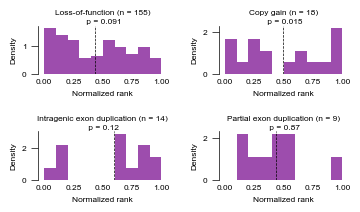

In [36]:
fig, axes = plt.subplots(2, 2, figsize = (4, 2), gridspec_kw = {'hspace': 1.2, 'wspace': 0.4})

labels = ['Loss-of-function', 'Copy gain', 'Intragenic exon duplication', 'Partial exon duplication']
for i, sv_effect in enumerate(['PREDICTED_LOF', 'PREDICTED_COPY_GAIN', 'PREDICTED_INTRAGENIC_EXON_DUP', 'PREDICTED_PARTIAL_EXON_DUP']):
    
    ax = axes.flat[i]
    
    sv_subset = heatmap_rna_results.query(f'genic_relationship == "{sv_effect}"')
    num_genes = len(sv_subset)
    
    ax.hist(sv_subset['mean_greater_0_dosage_rank'],
            bins = np.arange(0, 1.1, 0.1), color = mc.palette['neuroblastoma']['main'], density = True)
    
    sns.despine(ax = ax, bottom = True)
    ax.tick_params(axis = 'x', length = 0)
    ax.set_title(labels[i] + f' (n = {num_genes})', fontsize = 6, y = 1.05)
    
    rank_deviation = np.abs(0.5 - sv_subset['mean_greater_0_dosage_rank'])
    ref_dist = stats.norm(loc = 0.25, scale = np.sqrt(1/(48 * num_genes)))
    p = 1 - ref_dist.cdf(rank_deviation.mean())
    ax.text(s = " p = {:.2g}".format(p), x = 0.5, y = 1.15, fontsize = 6,
            ha = 'center', va = 'top', transform = ax.transAxes)
    ax.set_xlabel('Normalized rank')

    mean = np.mean(sv_subset['mean_greater_0_dosage_rank'])
    ax.axvline(x = mean, color = 'black', linestyle = 'dashed', linewidth = 0.5)
    ax.set_ylabel('Density')
    
fig.savefig('figures/effect-on-expression-by-sv-effect.pdf', bbox_inches = 'tight')